In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sympy import *
from scipy.integrate import quad
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
init_printing()

In [2]:
N,V,T,Q,L,q,k,h,m,beta = symbols("N V T Q Lambda q k h m beta", positive=True, real=True)
E,S,F,A = symbols("E S G A", real=True)

# Ideal monatomic gas

Here we show how to use `sympy` to symbolically manage expressions, take the derivative etc.

#### Partition function

In [3]:
L = h/sqrt(2*pi*m/beta) # de Broglie wavelength
q = V/L**3              # translational partition function
Q = q**N / factorial(N) # molecular part. func.; independent particles

#### Energy

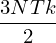

In [4]:
E = -diff(ln(Q), beta)
E.subs(beta, 1/(k*T))

#### Free energy (experimental section)

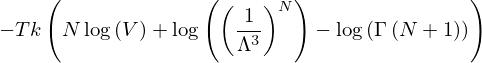

In [5]:
L = symbols('Lambda')
Q = (V/L**3)**N / factorial(N)
F = -k*T*ln(Q)
F = simplify(F)
F

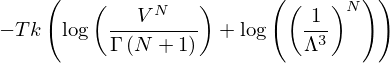

In [6]:
F = F.subs( log(factorial(N)), N*log(N)-N ) # stirling's approximation
logcombine(F)

# Rotational Partition Function

The following plots the rotational partition function and how each quantum number, $J$, contributions. We use `ipywidgets` to add an interactive slider to control the temperature.
The manual for `ipywidgets` can be found [here](https://ipywidgets.readthedocs.io/en/latest/index.html).

In [17]:
from scipy.constants import h, c, k, N_A
from scipy.misc import derivative 

B = 10.591 * 100 # 1/m # rotational wave-number (related to moment of inertia)
J = np.arange(0,15,1)  # quantum numbers (called "l" in Dill's book)

def q(J,beta):
    ''' rotational partition function for a given J '''
    return (2*J+1) * np.exp( -beta*h*c*B*J*(J+1) )

def qrot(beta):
    ''' partition function for "inifinite" number of quantum numbers '''
    J = np.arange(0,500,1)
    return np.sum( q(J,beta) )

def qrotHT(beta):
    ''' partition function in the high temperature limit, i.e. summation --> integral '''
    return 1/(beta*h*c*B)

def plot(T):
    ''' plots partition function at given temperature '''
    beta = 1/(k*T)
    plt.plot( J, q(J,beta).cumsum(), 'b--o', alpha=0.7, lw=2, ms=10,
             label=r'Explicit summation <$E$>={:.2f} kT'
             .format(-derivative( qrot, beta, dx=0.001*beta ) / qrot(beta) * beta) )
    plt.plot( [0,1000], [qrotHT(beta),qrotHT(beta)], 'r-', alpha=0.5, lw=4,
             label=r'High temperature limit <$E$>={:.2f} kT'
             .format(-derivative( qrotHT, beta, dx=0.001*beta ) / qrotHT(beta) * beta))
    plt.xlim( 0, 14 )
    plt.xlabel( 'Quantum number, $J$' )
    plt.ylabel( 'Summed partition function, $q$' )
    plt.legend(loc=0, frameon=False)
    plt.title('Rotational Partition Function, $q_r$')

# this part sets up a temperature slider to control the plot
i = interact_manual(plot, T=(50, 1000), continuous_update=False )
i.widget.children[0].description=r'$T$ (Kelvin)'

interactive(children=(IntSlider(value=525, description='T', max=1000, min=50), Button(description='Run Interac…

# Two-level system

Here we consider a system where two energy level are possible; the ground state (0) and the first excited state, $\epsilon$. The partition function is

$$
q = 1+e^{-\epsilon / k_BT}
$$

Text(0.5, 0, 'Temperature')

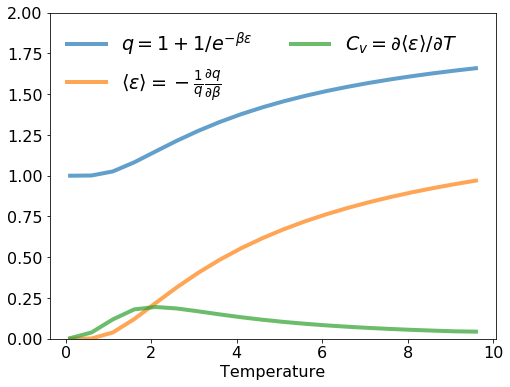

In [16]:
from scipy.constants import h, c, k, N_A # import physical constants

def q(T): return 1+np.exp(-epsilon/(k*T))
def energy(T): return epsilon / (np.exp(epsilon/(k*T)+1) ) # atkins p625 (10th)
def Cv(T): return np.gradient( energy(T)/k, T[1]-T[0] )

fig, ax = plt.subplots()
epsilon=k*4
T=np.arange(0.1, 10, 0.5)
plt.plot(T,q(T), label=r'$q = 1+1 / e^{-\beta \epsilon}$', lw=4, alpha=0.7)
plt.plot(T, energy(T)/k, label=r'$\langle \epsilon \rangle = -\frac{1}{q}\frac{\partial q}{\partial \beta}$',
         lw=4, alpha=0.7)
plt.plot(T, Cv(T), label=r'$C_v=\partial \langle \epsilon \rangle / \partial T$', lw=4, alpha=0.7)
plt.legend(frameon=False, loc=0, fontsize='large', ncol=2)
plt.ylim(0, 2)
plt.xlabel('Temperature')

# Bragg-Williams Model for a Two-component System

This example demonstrates how the Bragg-Williams (BW) model predicts the partial pressure of compoments A and B over a liquid mixture of the two. The interaction parameter $\alpha$ includes the relative A-B neighbor interaction, compared to the A-B and B-B interactions, as well as the number of neighbors, $z$. The partial pressure is given by,
$$
p_A = p_A^0 \chi_A e^{\alpha \chi_B^2}
$$

where $p_A^0$ is the vapor pressure of pure A. If either $\alpha$ or the mole fraction, $\chi_B$, of the other component approach zero, ideal behavior, i.e. Rault's law, is obtained:
$$
p_A = p_A^0 \chi_A
$$

In [14]:
chiA = np.arange(0,1.1,0.05) # mole fraction of A
chiB = 1-chiA                # mole fraction of B

def plotbw(alpha=1, p0A=0.7, p0B=0.2):
    plt.plot( chiA, chiA * p0A * np.exp(alpha*chiB**2),'b-', label='Bragg-Williams'  )
    plt.plot( chiA, chiA * p0A, 'b--', label="Rault's law")    
    plt.plot( chiA, chiB * p0B * np.exp(alpha*chiA**2),'r-')
    plt.plot( chiA, chiB * p0B, 'r--')
    plt.xlim(0,1)

    plt.xlabel(r'$\chi_A=1-\chi_B$')
    plt.ylabel(r'$p$', color='k')
    
    plt.annotate(r'$p_A^0$', (1,p0A), color='blue')
    plt.annotate(r'$p_B^0$', (0,p0B), color='red')
    plt.legend(loc=0, frameon=False)

i = interact(plotbw, alpha=(-3,3, 0.5), p0A=(0,1,0.1), p0B=(0,1,0.1), continuous_update=False )

i.widget.children[0].description=r'$\alpha$'
i.widget.children[1].description=r'$p_A^0$'
i.widget.children[2].description=r'$p_B^0$'

interactive(children=(FloatSlider(value=1.0, description='alpha', max=3.0, min=-3.0, step=0.5), FloatSlider(va…

# Equation of State using Generalized van der Waals Theory

This notebook illustrates the generalized van der Waals theory (gvdW) for the equation of state for interacting particles. Based on the lecture notes, _Properties of Molecular Fluids in Equilibrium_ by Sture Nordholm.

### Pair potential

The particles are here assumed to interact via a _Lennard-Jones_ potential,
$$
\beta w(r) =
4\beta \varepsilon_{LJ} \left ( \left ( \frac{\sigma}{r}\right )^{12} - \left ( \frac{\sigma}{r}\right )^{6}\right )
$$

Any potential may in principle be given and must return the energy in units of $k_BT=\beta^{-1}$.

### Interaction parameter

Here we integrate the above pair potential to get the average interaction energy per particle, assuming that the pair correlation function, $g(r)$, can be described by a simple step function, zero when $r<\sigma$, unity otherwise:
$$ 
\hat{a} = -\frac{1}{2} \int_{\sigma}^{\infty} 4\pi w(r) r^2 dr
$$

In this Notebook we simply do the integration numerically so that we can use arbitrary pair potentials.
From this we calculate the pressure, $p$, versus density, $n$, using,
$$
\beta p_{gvdW} = \frac{1}{v-v_0} - \frac{\hat{a}}{v^2}
$$

where $v=1/n$ and $v_0=2\pi\sigma^3/3$ is the particle volume.
For reference we'll also plot EOS for an ideal system (van 't Hoff), $\beta p_{ideal}=n$,
where $\beta = 1/k_BT$.

In [15]:
def pairpotential(r, eps, sigma): # Lennard-Jones potential
    return 4 * eps * ( (sigma/r)**12 - (sigma/r)**6 )

def Pgvdw(n, eps, sigma):
    a  = -2*pi*quad(lambda r: pairpotential(r, eps, sigma)*r**2, sigma, np.infty, limit=20)[0]
    v0 = 2*pi*sigma**3 / 3
    v  = 1 / n
    return 1/(v-v0) - a/v**2

def Pideal(n): # ideal gas law
    return n

def plot( eps=0, sigma=4.0 ):
    plt.plot(n, Pideal(n),  'k--', label='ideal', lw=2)
    plt.plot(n, Pgvdw(n, eps, sigma),  'r-', label='gvdW', lw=2)
    plt.legend(loc=0, frameon=False)
    
    plt.xlabel(r'Density, $n$')
    plt.ylabel(r'Pressure, $\beta p$')

n = np.linspace(1e-7, 6e-3, 50)    
i = interact(plot, eps=(0.0, 2.0, 0.1), sigma=(0, 5, 0.1), continuous_update=False )
 
i.widget.children[0].description=r'$\beta\varepsilon_{LJ}$'
i.widget.children[1].description=r'$\sigma_{LJ}$'

interactive(children=(FloatSlider(value=0.0, description='eps', max=2.0), FloatSlider(value=4.0, description='…

## Variation of Dill problem 5.1 (page 91)

Let's assume that each corner (n, s, e, w) are associated with an energy, $\epsilon_i$. Specifically we set an attraction for north ($\beta\epsilon_n=-0.5$) and a repulsion for south ($\beta\epsilon_s = 0.5$).

In [9]:
energy = np.array([-0.5, 0.5, 0.0, 0.0])
p = np.exp(-energy) / np.exp(-energy).sum()
entropy = -(p*np.log(p)).sum()
print("p_i =", p)
print("sum(p_i) =", p.sum())
print("S/k = {:.3f}".format(entropy))

p_i = [0.38745562 0.14253696 0.23500371 0.23500371]
sum(p_i) = 1.0
S/k = 1.326
